## QPO's Using Gaussian Processes

In this notebook we will see how to use the stingray API, to model a Gaussian Process and fit it on to a stingray Lightcurve object. We can use different types of models to fit a Quasi Periodic oscillation on the lightcurve.

Tinygp library is to be used for this method, and also jax need to be installed.

In [1]:
# Loading Dependencies

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from tinygp import GaussianProcess
from stingray import Lightcurve
jax.config.update("jax_enable_x64", True)

/Users/gaurav/Desktop/Open/stingray/stingray/utils.py:35: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")


We will make a sinosoidal lightcurve with poisson noise

In [2]:
dt = 0.03125  # seconds
exposure = 8.  # seconds
times = np.arange(0, exposure, dt)  # seconds

signal_1 = 300 * np.sin(2.*np.pi*times/0.5) + 1000 #1000  # counts/s
noisy_1 = np.random.poisson(signal_1*dt)  # counts

lc1 = Lightcurve(times, noisy_1)

#### Gaussian Processs Regressor
We will use the GP class, which takes in a lightcurve object and fits a gaussian regressor on to it, based on our model choice.

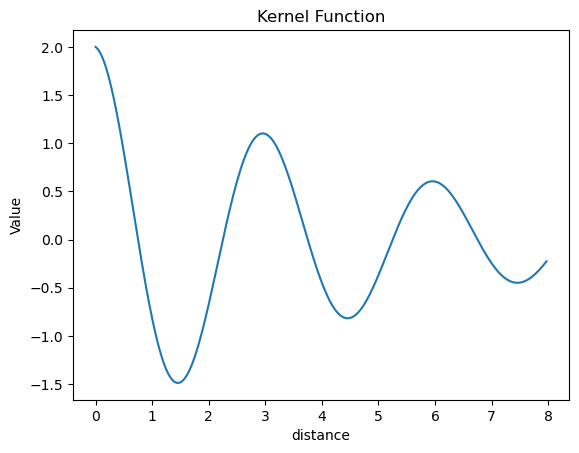

In [3]:
from stingray.modeling.gpmodelling import GP, GPResult

# Model Parameters to be used in making the Gaussian Process

Model_type = ("qpo", "zero")
params = {
    "amp": jnp.exp(np.log([2.0])),
    "decay": jnp.exp(np.log([1.0/5.0])),
    "freq": jnp.exp(np.log([1.0/3.0,])),
    "diag": 1e-1,
    "mean": 0.0,                
}

GP1 = GP(lc1, Model_type, params)
GP1.plot_kernel()

In [4]:
print("The log-probability of the lightcurve is: ",GP1.get_logprob())
GP1.get_model()

The log-probability of the lightcurve is:  -74354.06137058939


(('qpo', 'zero'),
 {'amp': Array([2.], dtype=float64),
  'decay': Array([0.2], dtype=float64),
  'freq': Array([0.33333333], dtype=float64),
  'diag': 0.1,
  'mean': 0.0})

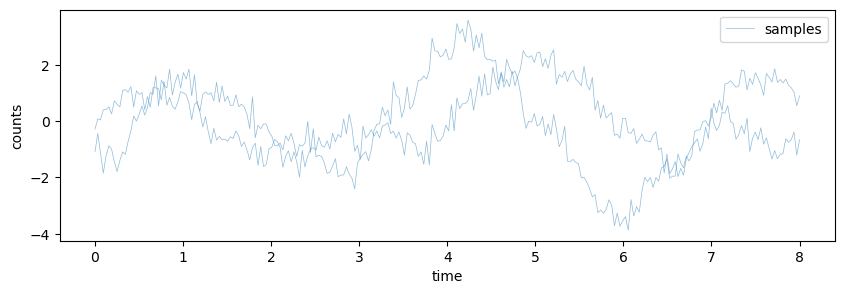

In [5]:
# Picking some samples out of the Gaussian Process
X_test = np.linspace(0, 8, 256)
GP1.plot_originalgp(X_test, sample_no= 2)

We will use GP.plot_gp to condition the gaussian proccess on the lightcurve

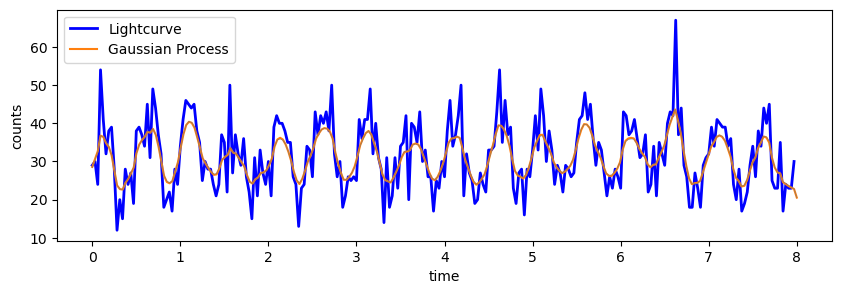

In [6]:
GP1.plot_gp(X_test)

#### Bayesian Inferencing
We will use the GPResult class for hyperparameter estimation, which takes in a GP class, and has functions which perform sampling and parameter estimation. We are using Numpyro library for NUTS sampling and posterior modelling.

In [7]:
prior_type = ("qpo", "zero")
GPresult = GPResult(GP1, prior_type)
GPresult.run_sampling()

/Users/gaurav/Desktop/Open/stingray/stingray/modeling/gpmodelling.py:266: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = MCMC(


We can check the parameters after sampling and also tabulate them

In [8]:
GPresult.get_parameters()

{'amp': Array(4.99926503, dtype=float64),
 'decay': Array(4.99816021, dtype=float64),
 'freq': Array(0.01092581, dtype=float64)}

In [9]:
GPresult.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       amp      5.00      0.00      5.00      5.00      5.00   1305.70      1.00
     decay      5.00      0.00      5.00      5.00      5.00   1228.55      1.00
      freq      0.01      0.01      0.01      0.00      0.02   1131.34      1.00

Number of divergences: 0


Plotting the best hyperparamters of the gaussian process

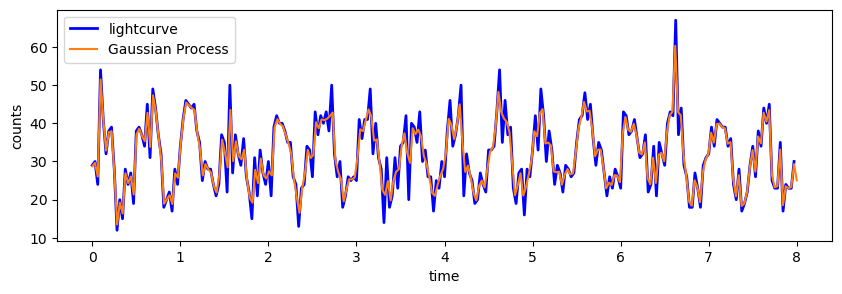

In [10]:
X_test = np.linspace(0, 8, 256)
GPresult.plot_posterior(X_test)